This notebook aims at making Hovmöller diagram to plot the time evolution of tracer profiles.

The functions include two main parts: 

* selecting the section I want to look at

* loading corresponding data over the model period

In [1]:
import copy,os,glob
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
% matplotlib inline

In [2]:
nc_filename = sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/para60Run/result/ENG319582008.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc = nc.Dataset(nc_filename[0])

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/para60Run/result/ENG319582008.nc']


In [3]:
lon = ptrc.variables['nav_lon'][:,:]
lat = ptrc.variables['nav_lat'][:,:]
dep  =  ptrc.variables['deptht'][:]


tmask = nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy = tmask.variables['mbathy'][0,400:,:]
tmask = tmask.variables['tmask'][0,:,400:,:]


bathy = nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = bathy.variables['Bathymetry'][400:,:]

In [4]:
uvel = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')
vvel = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')

In [5]:
yearnum = len(ptrc.variables['TR_7'][:,0,0,0])

In [6]:
# Visualize cross-sections

In [7]:
def map(boundinglat = 67):
    '''
    This function is used to create a circle region centered on the north pole.
    ===========================================================================
    arg:  boundinglat: the latitude circle boundinglat (default is set to be 67). 
    type: boundinglat: can be either floats or interger
    '''
    m  =  Basemap(projection = 'npstere',boundinglat = boundinglat,lon_0 = 0,resolution = 'l',round = 'TRUE')
    m.drawcoastlines()
    m.fillcontinents(color  =  '0.75')
    m.drawparallels(np.arange(70.,80.,2.),labels = [1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels = [0, 0, 1, 1])
    x_lon,y_lat  =  m(lon,lat)
    m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color = 'k',linewidth = 0.1)
    cs = m.contour(x_lon,y_lat,bathy,linewidth = 0.075,colors = 'black',alpha = 0.3)
    return m,x_lon,y_lat


def section(x0,y0,length,xi,yi):
    '''
    This function is to find the lat/lon for interested sections
    ============================================================================
    arg:  x0, y0: the starting point of the section.  
    type: x0, y0: interger
    
    arg:  length: length of the section  (Longer the section, bigger this number)
    type: length: interger
    
    arg:  xi, yi: slope  example: xi  =  0.5 then x0 + 0.5 * i
    type: xi, yi: floats/interger 
                 (If choose floats, index could be floats as well but it will Round to nearest integer)
    
    '''
    a = [] #index for the first dimension
    b = [] #index for the second dimension
    for i in range (length):
        a.append(x_lon[x0 + xi*i,y0 + yi*i])
        b.append(y_lat[x0 + xi*i,y0 + yi*i])
    return a,b



/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


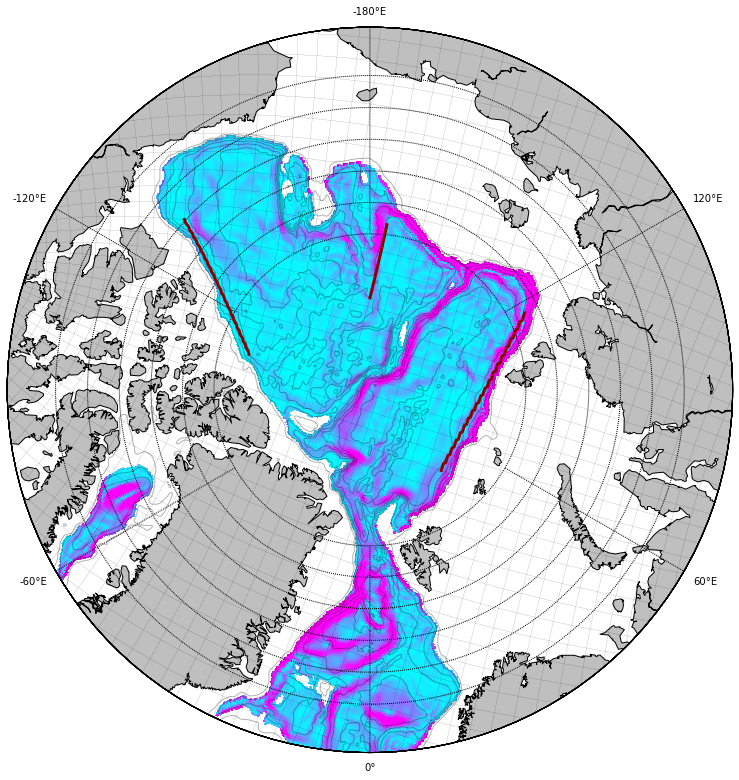

In [8]:
# test functions above

fig  =  plt.figure(figsize = (13,13))
ax  =  fig.add_subplot()
m,x_lon,y_lat = map()

#sec1 Makarov
a_mb,b_mb = section(x0 = -145,y0 = 290,length = 40,xi = 1,yi = 0)
m.plot(a_mb[:],b_mb[:],color = 'darkred',linewidth = 3)


#sec2 Nansen
a_ns,b_ns = section(x0 = -230,y0 = 358,length = 100,xi = 1,yi = 0.2)
m.plot(a_ns[:],b_ns[:],color = 'darkred',linewidth = 3)


#sec3 CB
a_,b_ = section(x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)
m.plot(a_[:],b_[:],color = 'darkred',linewidth = 3)


# plot one velocity snapshot, make sure my profile is not far away from the pathway
data  = (uvel.variables['vozocrtx'][5,35,400:,:]**2 + vvel.variables['vomecrty'][5,35,400:,:]**2)**0.5
m.pcolor(x_lon,y_lat,data[:,:],cmap = 'cool',vmax = 0.04)

[CB](#another_cell)

In [9]:
# prepeare functions for exacting time series data for the section

In [10]:
time_plt = np.linspace(1958,1958 + yearnum-1,yearnum)

In [11]:
def section_hovmoller(data,layer,x0,y0,length,xi,yi):
    '''load data for vertical profiles, return to tracer/cooridination 
     ================================================================
     
    arg:  data: 4-dimension model result from NEMO model 
    type: data: np.array
    
    arg:  layer: for a desired depth of the field
    type: layer: interger
    
    arg:  length: length of the section  (Longer the section, bigger this number)
    type: length: interger   
    
    arg:  x0, y0: the starting point of the section.  
    type: x0, y0: interger

    arg:  xi, yi: slope  example: xi  =  0.5 then x0 + 0.5 * i
    type: xi, yi: floats/interger 
                 (If choose floats, index could be floats as well but it will Round to nearest integer)

    '''
    a = np.empty([yearnum,length]);  # array to hold cross-section data over the model period
    coordinate = np.empty(length)    # array to contain coordinate for that section
    signx = xi
    signy = yi
    for i in range (length):
        temp = data[:,layer,x0 + signx*i,y0 + signy*i]
        temp = np.ma.masked_where(tmask[layer,x0 + signx*i,y0 + signy*i]<= 0,temp)
        a[:,i] = temp
        coordinate[i] = lon[x0 + signx*i,y0 + signy*i]
    return a,coordinate

In [12]:
def crossS_vel_hov(layer,length,x0,y0,xi,yi):
    '''cross-section velocity (m/s), return to cross-section velocity/cooridination 
    ===============================================================================
    arg:  layer: for a desired depth of the field
    type: layer: interger
    
    arg:  length: length of the section  (Longer the section, bigger this number)
    type: length: interger   
    
    arg:  x0, y0: the starting point of the section.  
    type: x0, y0: interger

    arg:  xi, yi: slope  example: xi  =  0.5 then x0 + 0.5 * i
    type: xi, yi: floats/interger 
                 (If choose floats, index could be floats as well but it will round to nearest integer)

    '''
    a = np.empty([length]);             # array to restore cross-section data (for just one time step)
    coordinate = np.empty(length)       # array to contain coordinate for that section


    signx = xi;signy = yi
    zi = (yi**2 + xi**2)**0.5
    hold = np.empty([yearnum,length]);  # array to hold cross-section data over the model period
    for j in range (yearnum):
        u = vel(keyword = 'U',T = 1958 + j,ENG = 'ENG3')[layer,:,:]
        v = vel(keyword = 'V',T = 1958 + j,ENG = 'ENG3')[layer,:,:]
        
        for i in range (length):
                # u,v --> cross-section velocity
                temp = u[x0 + signx*i,y0 + signy*i]*yi/zi - v[x0 + signx*i,y0 + signy*i]*xi/zi
                # mask
                temp = np.ma.masked_where(tmask[layer,x0 + signx*i,y0 + signy*i]<= 0,temp)
                a[i] = temp
                coordinate[i] = lon[x0 + signx*i,y0 + signy*i]
        hold[j,:] = a[:]
    return hold,coordinate


def alongS_vel_hov(layer,length,x0,y0,xi,yi):
    '''Along-section velocity (m/s), return to along-section velocity/cooridination 
    ===============================================================================
    arg:  layer: for a desired depth of the field
    type: layer: interger
    
    arg:  length: length of the section  (Longer the section, bigger this number)
    type: length: interger   
    
    arg:  x0, y0: the starting point of the section.  
    type: x0, y0: interger

    arg:  xi, yi: slope  example: xi  =  0.5 then x0 + 0.5 * i
    type: xi, yi: floats/interger 
                 (If choose floats, index could be floats as well but it will Round to nearest integer)

    '''
    a = np.empty([length]); 
    coordinate = np.empty(length)


    signx = xi;signy = yi
    zi = (yi**2 + xi**2)**0.5
    hold = np.empty([yearnum,length]);
    for j in range (yearnum):
        u = vel(keyword = 'U',T = 1958 + j,ENG = 'ENG3')[layer,:,:]
        v = vel(keyword = 'V',T = 1958 + j,ENG = 'ENG3')[layer,:,:]
        for i in range (length):
                # u,v --> Along-section velocity
                temp = u[x0 + signx*i,y0 + signy*i]*xi/zi + v[x0 + signx*i,y0 + signy*i]*yi/zi
                temp = np.ma.masked_where(tmask[layer,x0 + signx*i,y0 + signy*i]<= 0,temp)
                a[i] = temp
                coordinate[i] = lon[x0 + signx*i,y0 + signy*i]
        hold[j,:] = a[:]
    return hold,coordinate

In [13]:
def vel(keyword,T,ENG = 'ENG3'):
    '''
    This function is designed to obtain velocity field
    ======================================================
    arg:  keyword: three options. can choose 'U', 'V' or 'W'
    type: keyword: string
    
    arg:  T: calender year 
    type: T: string
    
    arg:  ENG: choose run series, for example, ENG3, ENG4, EXH001, EXH005
    type: ENG: string
    '''
    if keyword  == 'U':
        nc_filename = sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s.nc'%(ENG,T)))
        uvel = nc.Dataset(nc_filename[0])
        data  = uvel.variables['vozocrtx'][0,:,400:,:]
    elif keyword  == 'V':
        nc_filename = sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s.nc'%(ENG,T)))
        vvel = nc.Dataset(nc_filename[0])
        data  = vvel.variables['vomecrty'][0,:,400:,:]
    else:
        nc_filename = sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*W*%s.nc'%(ENG,T)))
        wvel = nc.Dataset(nc_filename[0])
        data  = wvel.variables['vovecrtz'][0,:,400:,:]
    data  = np.ma.masked_where(tmask == 0,data)
    return data


# CB tracer

In [15]:
# test run time
% timeit temp,coor = section_hovmoller(data = ptrc.variables['TR_7'],layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)
% timeit temp2,coor = section_hovmoller(data = ptrc.variables['TR_8'],layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1 loop, best of 3: 8.93 s per loop


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1 loop, best of 3: 8.84 s per loop


In [16]:
# preprae data -- diss. Pa
temp,coor = section_hovmoller(data = ptrc.variables['TR_7'],layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)
# preprae data -- diss. Th
temp2,coor = section_hovmoller(data = ptrc.variables['TR_8'],layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)
# preprae data -- diss. Pa/Th
Temp = temp[:,:]/temp2[:,:]
Temp = np.ma.masked_where(temp == 0,Temp)

# preprae data -- vel
uhold,coordinate =  alongS_vel_hov(layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)
vhold,coordinate =  crossS_vel_hov(layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)

# preprae data -- part. Pa
ptemp1,coor = section_hovmoller(data = ptrc.variables['TR_9'],layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)
ptemp1 = np.ma.masked_where(ptemp1 == 0,ptemp1)
# preprae data -- part. Th
ptemp2,coor = section_hovmoller(data = ptrc.variables['TR_10'],layer = 35,x0 = 280,y0 = 170,length = 40,xi = -2,yi = 1.5)
ptemp2 = np.ma.masked_where(ptemp2 == 0,ptemp2)

# preprae data -- part. Pa/Th
pTemp = ptemp1[:,:]/ptemp2[:,:]
pTemp = np.ma.masked_where(pTemp == 0,pTemp)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:70: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:72: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main_

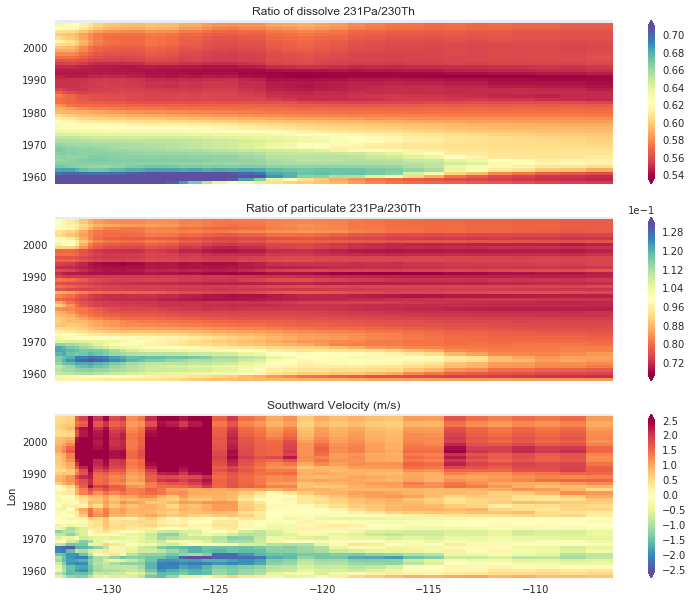

In [17]:
import seaborn as sns

fig  =  plt.figure(figsize = (15/1.2,12/1.2))

ax = plt.subplot(3,1,1)
plt.pcolormesh(coor[:],time_plt[:],Temp[:,:],cmap = 'Spectral',vmax = 0.71)#,v,vmin = vmin,vmax = vmax,cmap = plt.cm.Spectral_r);
cbar = plt.colorbar(extend = 'both')
ax.get_xaxis().set_ticklabels([])
plt.title('Ratio of dissolve 231Pa/230Th');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
        
ax = plt.subplot(3,1,2)


plt.pcolormesh(coordinate[:],time_plt[:],pTemp[:,:],cmap = 'Spectral');cbar = plt.colorbar(extend = 'both')
ax.get_xaxis().set_ticklabels([])
plt.title('Ratio of particulate 231Pa/230Th');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()


ax = plt.subplot(3,1,3)
plt.pcolormesh(coordinate,time_plt,uhold*100,cmap = 'Spectral_r',vmin = -2.5,vmax = 2.5)
cbar = plt.colorbar(extend = 'both')
plt.title('Southward Velocity (m/s)');
plt.ylabel('Lon');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())
#cbar.set_label('southward veolocity (cm/s)')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()


# MB tracer

In [50]:
# prepare data

In [51]:
# diss Pa
% timeit temp,coor = section_hovmoller(data = ptrc.variables['TR_7'],layer = 35,x0 = -145,y0 = 290,length = 40,xi = 1,yi = 0)

1 loop, best of 3: 10.1 s per loop


In [52]:
# part Th
temp2,coor = section_hovmoller(data = ptrc.variables['TR_8'],layer = 35,x0 = -145,y0 = 290,length = 40,xi = 1,yi = 0)
# vel
uhold,coordinate =  alongS_vel_hov(layer = 35,x0 = -145,y0 = 290,length = 40,xi = 1,yi = 0)
vhold,coordinate =  crossS_vel_hov(layer = 35,x0 = -145,y0 = 290,length = 40,xi = 1,yi = 0)

In [53]:
# ratio of diss. Pa/Th
Temp = temp[:,:]/temp2[:,:]
Temp = np.ma.masked_where(temp == 0,Temp)

In [54]:
# part. Pa
ptemp1,coor = section_hovmoller(data = ptrc.variables['TR_9'],layer = 35,x0 = -145,y0 = 290,length = 40,xi = 1,yi = 0)
ptemp1 = np.ma.masked_where(ptemp1 == 0,ptemp1)
# part. Th
ptemp2,coor = section_hovmoller(data = ptrc.variables['TR_10'],layer = 35,x0 = -145,y0 = 290,length = 40,xi = 1,yi = 0)
ptemp2 = np.ma.masked_where(ptemp2 == 0,ptemp2)

# ratio of part. Pa/Th
pTemp = ptemp1[:,:]/ptemp2[:,:]
pTemp = np.ma.masked_where(pTemp == 0,pTemp)

(174.10356140136719, 179.98170471191406)

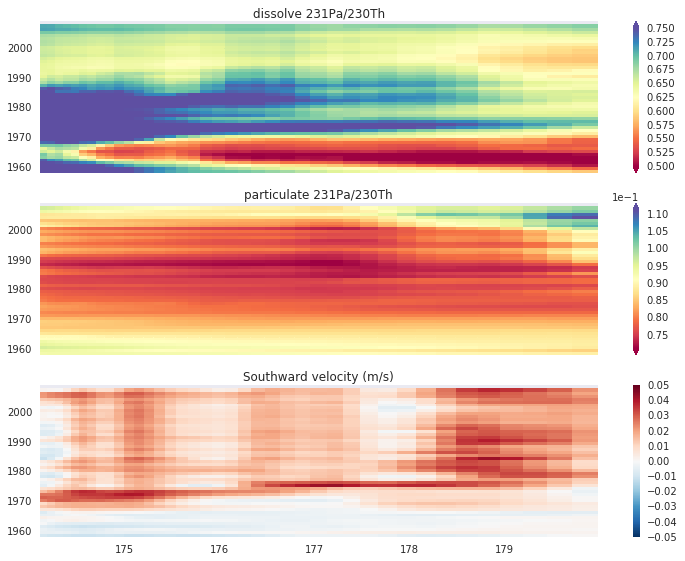

In [55]:
#plots
fig  =  plt.figure(figsize = (15/1.2,15/1.2))

# diss pa/th ratio
ax = plt.subplot(4,1,1)
plt.pcolor(coor[:],time_plt[:],Temp[:,:],cmap = 'Spectral',vmax = 0.75,vmin = 0.50)#,v,vmin = vmin,vmax = vmax,cmap = plt.cm.Spectral_r);
cbar = plt.colorbar(extend = 'both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 231Pa/230Th');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
# part pa/th ratio
ax = plt.subplot(4,1,2)
plt.pcolor(coor[:],time_plt[:],pTemp[:,:],cmap = 'Spectral');cbar = plt.colorbar(extend = 'both')
ax.get_xaxis().set_ticklabels([])
plt.title('particulate 231Pa/230Th');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()

# velocity
ax = plt.subplot(4,1,3)
plt.pcolor(coordinate,time_plt,vhold,cmap = 'RdBu_r',vmin = -0.05,vmax = 0.05)
plt.colorbar();plt.title('Northward velocity (m/s)');
plt.ylabel('Lon')
plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())

# EB tracer 

In [56]:
temp,coor = section_hovmoller(data = ptrc.variables['TR_7'],layer = 35,x0 = -230,y0 = 358,length = 100,xi = 1,yi = 0.2)
temp2,coor = section_hovmoller(data = ptrc.variables['TR_8'],layer = 35,x0 = -230,y0 = 358,length = 100,xi = 1,yi = 0.2)
# vel
uhold,coordinate =  alongS_vel_hov(layer = 35,x0 = -230,y0 = 358,length = 100,xi = 1,yi = 0.2)
vhold,coordinate =  crossS_vel_hov(layer = 35,x0 = -230,y0 = 358,length = 100,xi = 1,yi = 0.2)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:70: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:72: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main_

In [57]:
Temp = temp[:,:]/temp2[:,:]
Temp = np.ma.masked_where(temp == 0,Temp)

In [58]:
ptemp1,coor = section_hovmoller(data = ptrc.variables['TR_9'],layer = 35,x0 = -230,y0 = 358,length = 100,xi = 1,yi = 0.2)
ptemp1 = np.ma.masked_where(ptemp1 == 0,ptemp1)
ptemp2,coor = section_hovmoller(data = ptrc.variables['TR_10'],layer = 35,x0 = -230,y0 = 358,length = 100,xi = 1,yi = 0.2)
ptemp2 = np.ma.masked_where(ptemp2 == 0,ptemp2)

pTemp = ptemp1[:,:]/ptemp2[:,:]
pTemp = np.ma.masked_where(pTemp == 0,pTemp)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(41.505165100097656, 116.45134735107422)

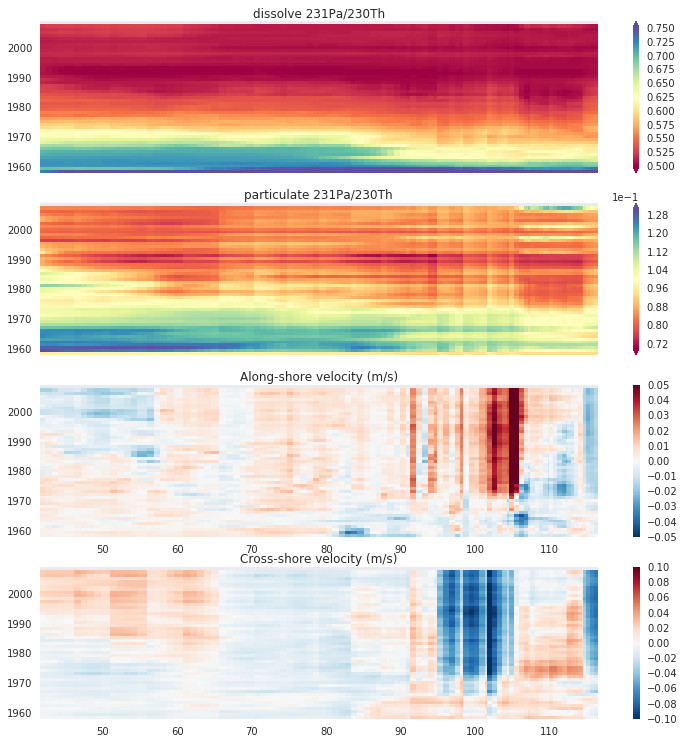

In [59]:
# make plots
fig  =  plt.figure(figsize = (15/1.2,15/1.2))
ax = plt.subplot(4,1,1)
plt.pcolor(coor[:],time_plt[:],Temp[:,:],cmap = 'Spectral',vmax = 0.75,vmin = 0.50)#,v,vmin = vmin,vmax = vmax,cmap = plt.cm.Spectral_r);
cbar = plt.colorbar(extend = 'both')
ax.get_xaxis().set_ticklabels([])
plt.title('dissolve 231Pa/230Th');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
        
ax = plt.subplot(4,1,2)
plt.pcolor(coor[:],time_plt[:],pTemp[:,:],cmap = 'Spectral');cbar = plt.colorbar(extend = 'both')
ax.get_xaxis().set_ticklabels([])
plt.title('particulate 231Pa/230Th');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())
#cbar.set_label('ratio')
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()

ax = plt.subplot(4,1,3)
plt.pcolor(coordinate,time_plt,uhold,cmap = 'RdBu_r',vmin = -0.05,vmax = 0.05)
plt.colorbar();plt.title('Along-shore velocity (m/s)');
plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())

ax = plt.subplot(4,1,4)
plt.pcolor(coordinate,time_plt,vhold,cmap = 'RdBu_r',vmin = -0.1,vmax = 0.1)
plt.colorbar();plt.title('Cross-shore velocity (m/s)');
plt.ylabel('Lon');plt.ylim(1958,1958 + yearnum);plt.xlim(coordinate.min(),coordinate.max())